In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.datasets
import sklearn.metrics
import itertools
import pickle
%matplotlib inline

In [2]:
class ScratchLogisticRegression:
    """
    ロジスティック回帰のスクラッチ実装

    Parameters
    ----------
    num_iter : int
      イテレーション数
    lr : float
      学習率
    no_bias : bool
      バイアス項を入れない場合はTrue
    lm : float
      正則化の強さ
    verbose : bool
      学習過程を出力する場合はTrue

    Attributes
    ----------
    self.coef_ : 次の形のndarray, shape (n_features, 1)
      パラメータ
    self.bias_ : 次の形のndarray, shape (1,)
      バイアス項
    self.loss : 次の形のndarray, shape (self.iter,)
      訓練データに対する損失の記録
    self.val_loss : 次の形のndarray, shape (self.iter,)
      検証データに対する損失の記録
    """
    def __init__(self, num_iter, lr=0.01, no_bias=False, lm=1, verbose=False):
        # ハイパーパラメータを属性として記録
        self.iter = num_iter
        self.lr = lr
        self.no_bias = no_bias
        self.lm = lm
        self.verbose = verbose
        # 学習するパラメータ
        self.coef_ = None
        self.bias_ = None
        # 損失を記録する配列を用意
        self.loss = np.zeros(self.iter)
        self.val_loss = np.zeros(self.iter)

    def _sigmoid(self, x):
        return 1 / (1 + np.exp(-x))
        
    def _hypothesis(self, X):
        z = X @ self.coef_
        if not self.no_bias:
            z = z + self.bias_
        return self._sigmoid(z)

    def _gradient_descent(self, X, y):
        error = self.predict_proba(X).ravel() - y
        # バイアス項以外を更新（L2 正則化する）
        self.coef_ = self.coef_ - self.lr * (((error @ X) / len(X)).reshape((-1, 1)) + self.lm / len(X) * self.coef_)
        # バイアス項を更新（正則化なし）
        if not self.no_bias:
            self.bias_ = self.bias_ - (self.lr * np.sum(error) / len(X))

    def fit(self, X, y, X_val=None, y_val=None):
        """
        ロジスティック回帰を学習する。検証データが入力された場合はそれに対する損失と精度もイテレーションごとに計算する。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            訓練データの特徴量
        y : 次の形のndarray, shape (n_samples, )
            訓練データの正解値
        X_val : 次の形のndarray, shape (n_samples, n_features)
            検証データの特徴量
        y_val : 次の形のndarray, shape (n_samples, )
            検証データの正解値
        """
        n_features = X.shape[1]
        self.coef_ = np.random.random((n_features, 1))
        if not self.no_bias:
            self.bias_ = np.zeros((1,))
        for i in range(self.iter):
            self._gradient_descent(X, y)
            y_pred = self.predict_proba(X)
            self.loss[i] = self._loss_func(y_pred, y)
            if X_val is not None and y_val is not None:
                y_pred_val = self.predict_proba(X_val)
                self.val_loss[i] = self._loss_func(y_pred_val, y_val)
            if self.verbose:
                # verboseをTrueにした際は学習過程を出力
                if X_val is not None and y_val is not None:
                    print("loss:", self.loss[i], "val_loss", self.val_loss[i])
                else:
                    print("loss:", self.loss[i])

    def predict(self, X):
        """
        ロジスティック回帰を使いラベルを推定する。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            サンプル

        Returns
        -------
            次の形のndarray, shape (n_samples,)
            ロジスティック回帰による推定結果
        """
        y = self.predict_proba(X)
        return np.where(y < 0.5, 0, 1).astype(np.int32)

    def predict_proba(self, X):
        """
        ロジスティック回帰を使い確率を推定する。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            サンプル

        Returns
        -------
            次の形のndarray, shape (n_samples,)
            ロジスティック回帰による推定結果
        """
        return self._hypothesis(X).ravel()
    
    def _loss_func(self, y_pred, y):
        return np.mean(-y * np.log(y_pred) - (1 - y) * np.log(1 - y_pred)) + self.lm / (2 * len(y)) * np.sum(self.coef_ ** 2)

    
    # 保存と読み込みを行う関数
    def save(self, filepath):
        with open(filepath, "wb") as f:
            pickle.dump(self, f)

    @classmethod
    def load(cls, filepath):
        with open(filepath, "rb") as f:
            return pickle.load(f)

#### 学習を行う

In [3]:
# 学習データの用意
data = sklearn.datasets.load_iris()

In [4]:
features = [
    'sepal_length',
    'sepal_width',
    'petal_length',
    'petal_width',
]

In [5]:
X = pd.DataFrame(data.data, columns=features)
y = pd.DataFrame(data.target, columns=["Species"])

In [6]:
# データクラスの選択
df = pd.concat([X, y], axis=1)
# label: versicolor = 1, virginica = 2
df_selected = df.query("Species in [1, 2]")
df_selected

,sepal_length,sepal_width,petal_length,petal_width,Species
50,7.0,3.2,4.7,1.4,1
51,6.4,3.2,4.5,1.5,1
52,6.9,3.1,4.9,1.5,1
53,5.5,2.3,4.0,1.3,1
54,6.5,2.8,4.6,1.5,1
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,2
146,6.3,2.5,5.0,1.9,2
147,6.5,3.0,5.2,2.0,2
148,6.2,3.4,5.4,2.3,2


In [7]:
# versicolor = 0, virginica = 1 となるように変換
df_selected = df_selected.assign(Species=df_selected["Species"] - 1)
df_selected

,sepal_length,sepal_width,petal_length,petal_width,Species
50,7.0,3.2,4.7,1.4,0
51,6.4,3.2,4.5,1.5,0
52,6.9,3.1,4.9,1.5,0
53,5.5,2.3,4.0,1.3,0
54,6.5,2.8,4.6,1.5,0
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,1
146,6.3,2.5,5.0,1.9,1
147,6.5,3.0,5.2,2.0,1
148,6.2,3.4,5.4,2.3,1


In [8]:
# 訓練データと検証データに分割
from sklearn.model_selection import train_test_split
X = df_selected.iloc[:, 0:4].to_numpy()
y = df_selected.iloc[:, 4].to_numpy()
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=131)

In [9]:
# 説明変数を標準化
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)
X_train_norm = scaler.transform(X_train)
X_valid_norm = scaler.transform(X_valid)
X_valid_norm

array([[ 0.68907362, -1.12773709,  1.08987898,  0.26771348],
       [ 0.99964201,  0.71346632,  0.25151053,  1.43168511],
       [-0.39791575,  0.09973185, -0.46709099, -0.43066951],
       [-0.86376834,  0.09973185, -0.82639175, -0.89625816],
       [-0.24263155,  0.09973185, -0.22755715, -0.66346383],
       [ 0.99964201,  0.71346632,  0.01197669, -0.43066951],
       [-1.32962092,  0.40659909, -0.46709099, -0.43066951],
       [-0.86376834, -0.20713538, -0.94615867, -0.89625816],
       [ 2.55248396,  2.86153697,  1.8084805 ,  0.73330213],
       [-0.24263155, -0.20713538, -0.22755715, -1.12905249],
       [ 0.68907362,  0.40659909,  0.37127745,  1.43168511],
       [ 0.06793684, -1.12773709,  0.01197669, -0.43066951],
       [-0.70848414, -0.51400262, -0.94615867, -1.59464114],
       [ 1.62077879,  0.09973185,  1.68871358,  0.26771348],
       [-0.55319995,  0.40659909,  0.25151053,  0.26771348],
       [-1.01905253,  0.40659909, -0.46709099, -0.43066951],
       [ 0.84435781,  1.

In [10]:
# 訓練する
logistic = ScratchLogisticRegression(300, lr=0.1, no_bias=False, verbose=True, lm=0.1)
logistic.fit(X_train_norm, y_train, X_valid_norm, y_valid)

loss: 0.4445748261176448 val_loss 0.42411114240698644
loss: 0.4388856262173679 val_loss 0.41807691131736807
loss: 0.4333856683736603 val_loss 0.41225236180575636
loss: 0.4280637532461012 val_loss 0.40662567281065637
loss: 0.42290965680898385 val_loss 0.4011859803267218
loss: 0.41791402365463676 val_loss 0.3959232795754729
loss: 0.4130682738022277 val_loss 0.3908283388545001
loss: 0.40836452111408217 val_loss 0.38589262350316167
loss: 0.4037955017102243 val_loss 0.381108228650783
loss: 0.39935451101392305 val_loss 0.3764678196057564
loss: 0.3950353482643242 val_loss 0.37196457890658796
loss: 0.3908322675033126 val_loss 0.36759215919367777
loss: 0.38673993418791086 val_loss 0.36334464117749965
loss: 0.3827533867012535 val_loss 0.35921649607819606
loss: 0.37886800213815996 val_loss 0.355202551996233
loss: 0.3750794658286111 val_loss 0.3512979637459703
loss: 0.3713837441365603 val_loss 0.34749818574575514
loss: 0.3677770601345786 val_loss 0.34379894761103874
loss: 0.3642558718086079 val_lo

In [11]:
y_pred = logistic.predict(X_valid_norm)
# 指標値を計算
print("Accuracy", sklearn.metrics.accuracy_score(y_valid, y_pred))
print("Precision", sklearn.metrics.precision_score(y_valid, y_pred))
print("Recall", sklearn.metrics.recall_score(y_valid, y_pred))
print("F1-Score", sklearn.metrics.f1_score(y_valid, y_pred))
print(sklearn.metrics.confusion_matrix(y_valid, y_pred))
# 結果も確認
print(list(y_valid))
print(list(y_pred))

Accuracy 1.0
Precision 1.0
Recall 1.0
F1-Score 1.0
[[11  0]
 [ 0  9]]
[1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1]
[1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1]


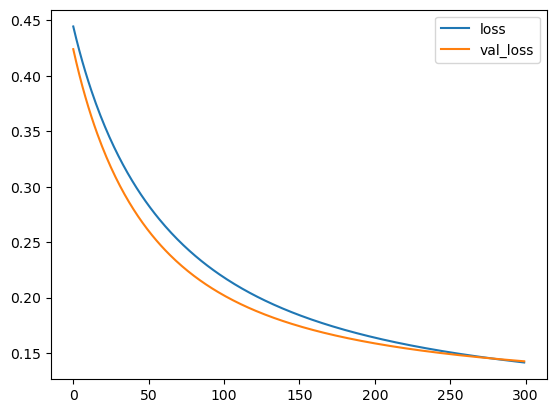

In [12]:
# 学習曲線のプロット
plt.plot(logistic.loss, label="loss")
plt.plot(logistic.val_loss, label="val_loss")
plt.legend()
plt.show()

#### scikit-learn との比較

In [13]:
from sklearn.linear_model import LogisticRegression
sklr = LogisticRegression(penalty="l2", C=10)
sklr.fit(X_train_norm, y_train)
y_pred = sklr.predict(X_valid_norm)
# 指標値を計算
print("Accuracy", sklearn.metrics.accuracy_score(y_valid, y_pred))
print("Precision", sklearn.metrics.precision_score(y_valid, y_pred))
print("Recall", sklearn.metrics.recall_score(y_valid, y_pred))
print("F1-Score", sklearn.metrics.f1_score(y_valid, y_pred))
print(sklearn.metrics.confusion_matrix(y_valid, y_pred))
# 結果も確認
print(list(y_valid))
print(list(y_pred))

Accuracy 1.0
Precision 1.0
Recall 1.0
F1-Score 1.0
[[11  0]
 [ 0  9]]
[1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1]
[1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1]


### 【問題7】決定領域の可視化

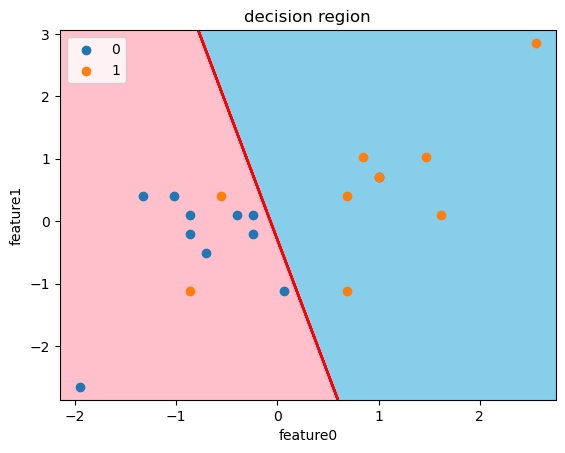

In [14]:
# 可視化のために2変数で学習し直す
X_train2 = X_train[:, 0:2]
X_valid2 = X_valid[:, 0:2]
scaler = StandardScaler()
scaler.fit(X_train2)
X_train_norm2 = scaler.transform(X_train2)
X_valid_norm2 = scaler.transform(X_valid2)
logistic = ScratchLogisticRegression(300, lr=0.1, no_bias=False, verbose=False, lm=0.1)
logistic.fit(X_train_norm2, y_train, X_valid_norm2, y_valid)

# 可視化
from matplotlib.colors import ListedColormap
def decision_region(X, y, slr):
    mesh_f0, mesh_f1  = np.meshgrid(
        np.arange(np.min(X[:,0]) - 0.2, np.max(X[:,0]) + 0.2, 0.002),
        np.arange(np.min(X[:,1]) - 0.2, np.max(X[:,1]) + 0.2, 0.002)
    )
    mesh = np.c_[np.ravel(mesh_f0), np.ravel(mesh_f1)]
    y_pred = slr.predict(mesh).reshape(mesh_f0.shape)
    plt.title('decision region')
    plt.xlabel('feature0')
    plt.ylabel('feature1')
    plt.contourf(mesh_f0, mesh_f1, y_pred,cmap=ListedColormap(['pink', 'skyblue']))
    plt.contour(mesh_f0, mesh_f1, y_pred,colors='red')
    plt.scatter(X[y==0][:, 0], X[y==0][:, 1],label='0')
    plt.scatter(X[y==1][:, 0], X[y==1][:, 1],label='1')
    plt.legend()
    plt.show()
decision_region(X_valid_norm2, y_valid, logistic)

### 【問題8】（アドバンス課題）重みの保存

In [15]:
# pikcle でモデルを保存する（作成した保存用メソッドを使う）
logistic.save("model.pkl")
print(logistic.coef_)
# 読み込み
l = ScratchLogisticRegression.load("model.pkl")
print(l.coef_)

[[1.00781172]
 [0.2349137 ]]
[[1.00781172]
 [0.2349137 ]]
